In [2]:
import math
import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.extensions import XGate
from qiskit import QuantumCircuit, Aer
from qiskit import transpile, assemble
from qiskit.circuit.library import XGate, RYGate

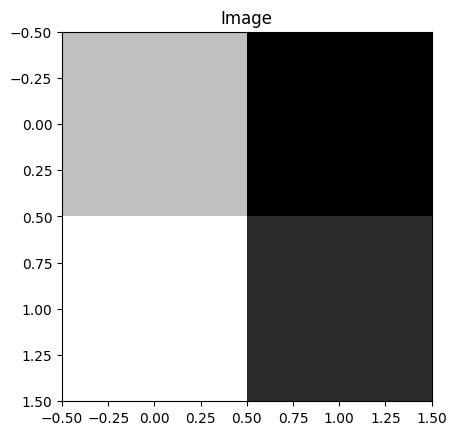

In [3]:
image = np.random.uniform(low=0, high=255, size=(2,2)).astype(int)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()

# FRQI

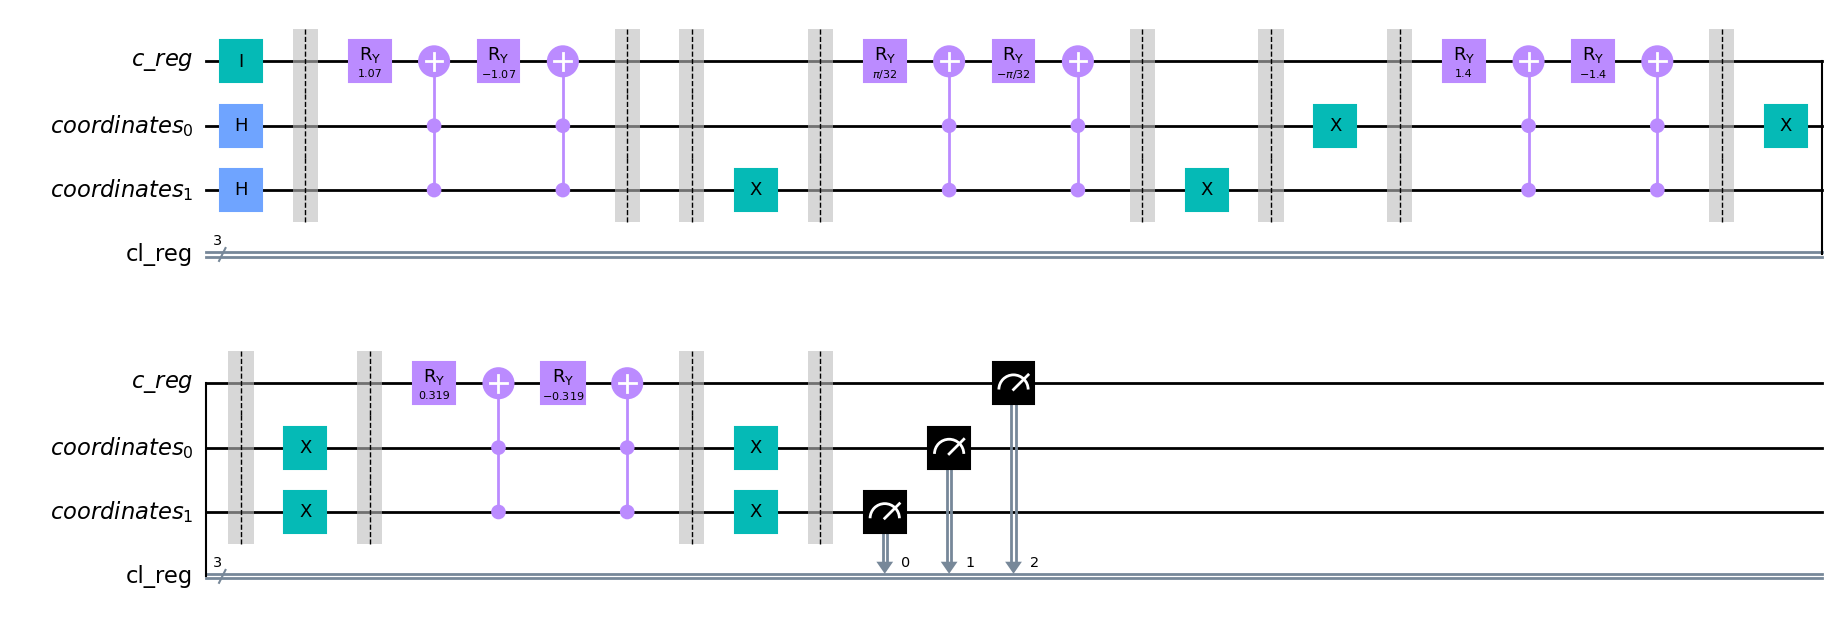

In [5]:
input_im = image.copy().flatten()
thetas = np.interp(input_im, (0, 256), (0, np.pi/2))
coord_q_num = int(np.ceil(math.log(len(input_im), 2)))

O = QuantumRegister(coord_q_num, 'coordinates')
c = QuantumRegister(1,'c_reg')
cr = ClassicalRegister(O.size+c.size, "cl_reg")

qc_frqi = QuantumCircuit(c, O, cr)
num_qubits = qc_frqi.num_qubits
input_im = image.copy().flatten()
qc_frqi.id(c)
qc_frqi.h(O)

controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])

for i, theta in enumerate(thetas):
    qubit_index_bin = "{0:b}".format(i).zfill(coord_q_num)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_frqi.x(O[k])
            
    qc_frqi.barrier()
    # for coord_or_intns in (0,1):
    qc_frqi.mcry(theta=2*theta,
                  q_controls=controls_,
                  q_target=c[0])

    qc_frqi.barrier()
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_frqi.x(O[k])
           
    qc_frqi.barrier()

qc_frqi.measure(list(reversed(range(qc_frqi.num_qubits))), list(range(cr.size)))
qc_frqi.draw('mpl')

# MCQRI

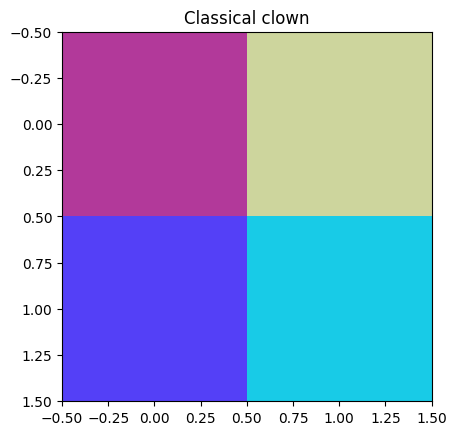

In [6]:
image = np.zeros((2,2,3))
image[:,:,0] = np.random.randint(low=0, high=256, size=(2,2))  
image[:,:,1] = np.random.randint(low=0, high=256, size=(2,2)) 
image[:,:,2] = np.random.randint(low=0, high=256, size=(2,2))  

plt.imshow(image.astype(np.uint8))
plt.title('Classical clown')
plt.show()


C:\Users\HCI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


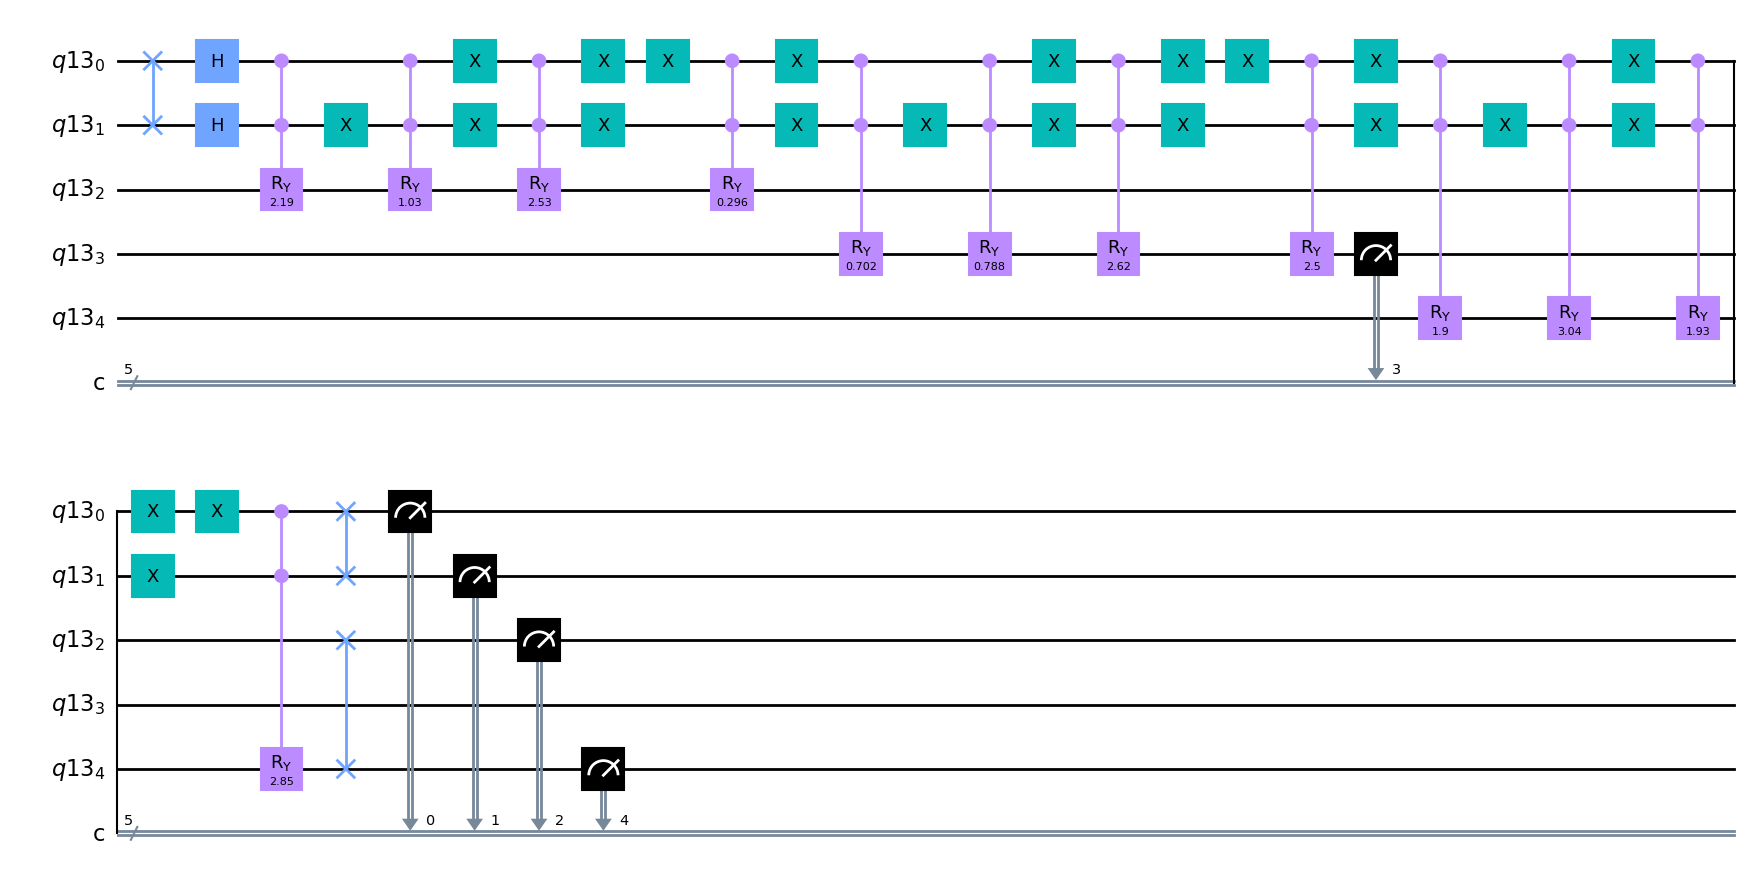

In [8]:
def params(image):
    xqbits = math.log(image.shape[0],2)
    yqbits = math.log(image.shape[1],2)
    return int(xqbits), int(yqbits)

def rgb_circ(image):
    xqbit, yqbit = params(image)
    qr = QuantumRegister(xqbit + yqbit + 3) #3 stands for RGB qubits
    # color = qr[xqbit + yqbit:]
    # coordinate = qr[:xqbit + yqbit]
    cr = ClassicalRegister(xqbit + yqbit + 3, 'c')
    qc = QuantumCircuit(qr, cr)

    for k in range(int(np.floor((xqbit + yqbit)/2))):
        qc.swap(k,xqbit + yqbit - 1 - k)

    for i in range(xqbit + yqbit):
        qc.h(i)

    for layer_num, input_im in enumerate(image.T):
        input_im = input_im.flatten()
        input_im = np.interp(input_im, (0, 255), (0, np.pi/2))

        for i, pixel in enumerate(input_im):
            arr = list(range(xqbit + yqbit))
            arr.append(int(xqbit + yqbit + layer_num))
            cMry = RYGate(2*pixel).control(xqbit + yqbit)

            to_not = "{0:b}".format(i).zfill(xqbit + yqbit)
            for j, bit in enumerate(to_not):
                if int(bit):
                    qc.x(j)

            qc.append(cMry, arr)

            if i!=len(input_im)-1 or layer_num!=2:
                for j, bit in enumerate(to_not):
                    if int(bit):
                        qc.x(j)


    for k in range(int(np.floor((xqbit + yqbit)/2))):
        qc.swap(k, xqbit + yqbit - 1 - k)

    qc.swap(-1, -3)

    for i in range(xqbit + yqbit + 3):
        qc.measure(i, i)

    return qc

qc_mcqri = rgb_circ(image)
qc_mcqri.draw('mpl')

# NEQR

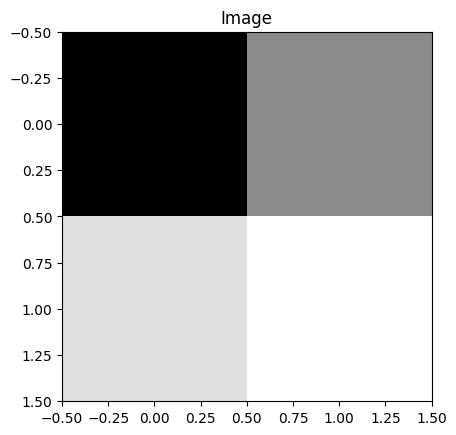

In [9]:
image = np.random.uniform(low=0, high=255, size=(2,2)).astype(int)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()

C:\Users\HCI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


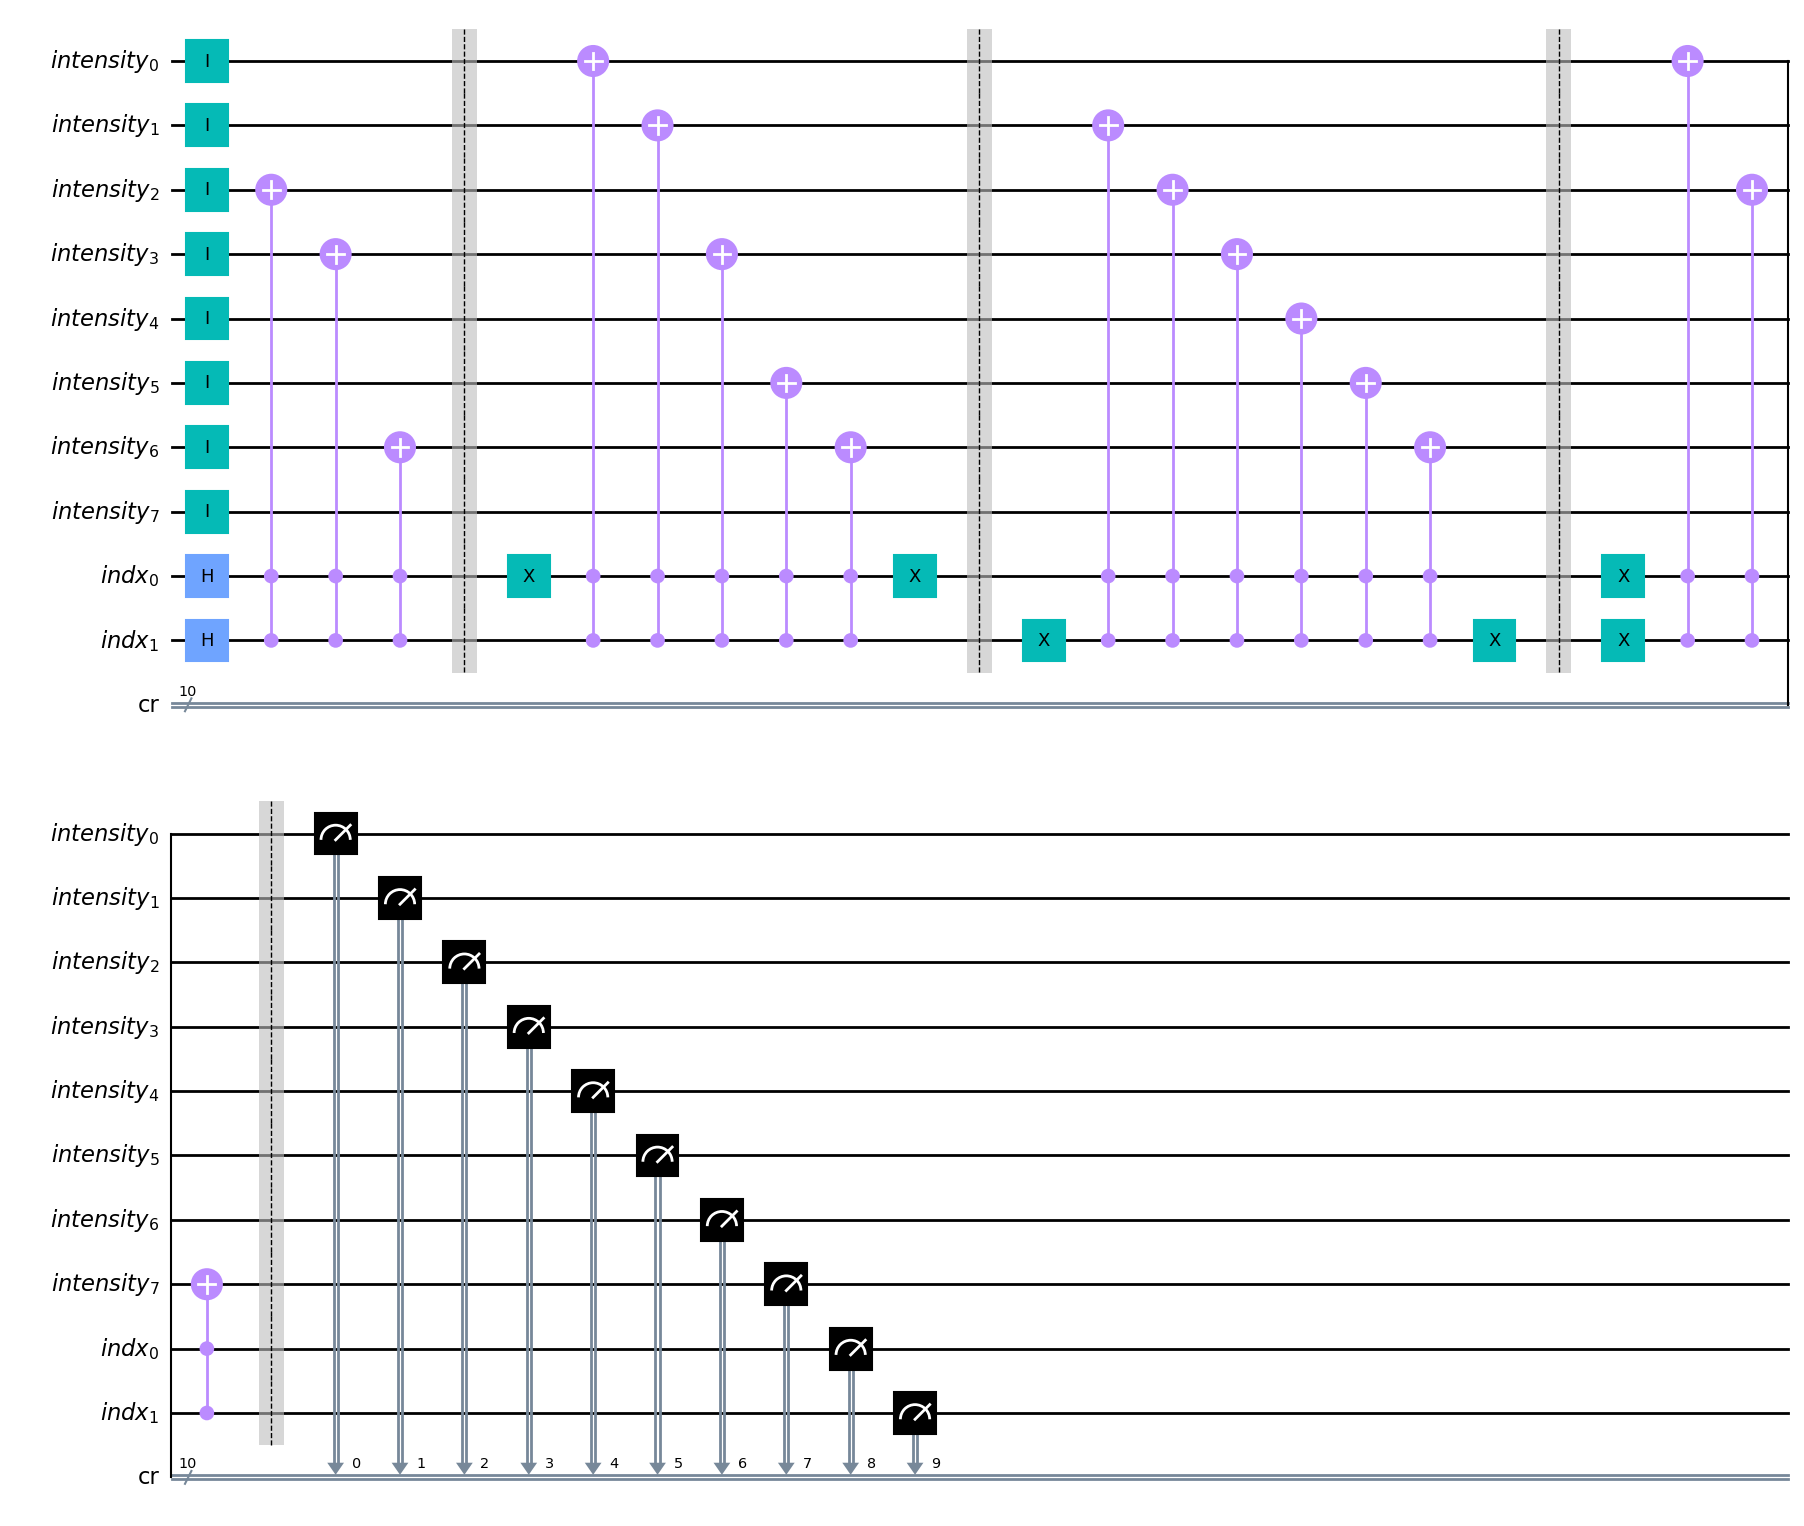

In [10]:
w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1
indx = QuantumRegister(w_bits+h_bits, 'indx')
intensity = QuantumRegister(8,'intensity')
cr = ClassicalRegister(len(indx)+len(intensity), 'cr')
qc_neqr = QuantumCircuit(intensity, indx, cr)
num_qubits = qc_neqr.num_qubits
input_im = image.copy().flatten()
qc_neqr.id(intensity)
qc_neqr.h(indx)
for i, pixel in enumerate(input_im):
    pixel_bin = "{0:b}".format(pixel).zfill(len(intensity))
    position = "{0:b}".format(i).zfill(len(indx))
    for j, coord in enumerate(position):
        if int(coord):
            qc_neqr.x(qc_neqr.num_qubits-j-1)
    for idx, px_value in enumerate(pixel_bin[::-1]):
        if(px_value=='1'):
            control_qubits = list(range(intensity.size, intensity.size + indx.size))
            target_qubit = intensity[idx]
            qc_neqr.mcx(control_qubits, target_qubit)
    if i!=len(input_im) - 1:
        for j, coord in enumerate(position):
            if int(coord):
                qc_neqr.x(qc_neqr.num_qubits-j-1)
    qc_neqr.barrier()
qc_neqr.measure(range(qc_neqr.num_qubits),range(cr.size))
qc_neqr.draw('mpl')

# QSMC/QSNC

C:\Users\HCI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


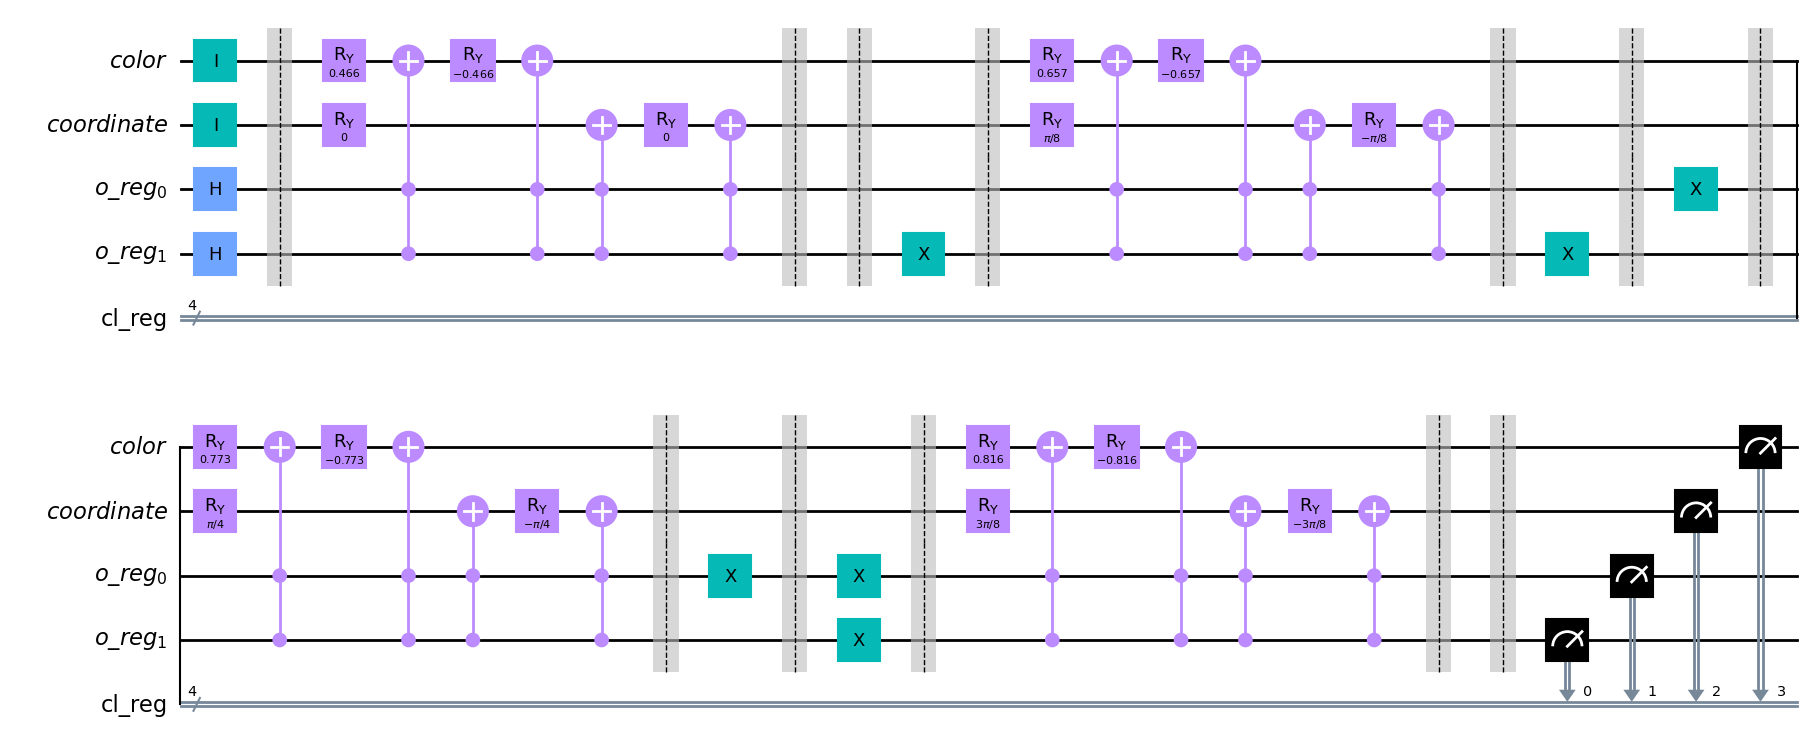

In [14]:
w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

im_list = image.flatten()
ind_list = sorted(range(len(im_list)), key=lambda k:im_list[k])
max_index = max(ind_list)
#now in angles: theta = intensity, phi = coordinate
thetas = np.interp(im_list, (0, 256), (0, np.pi/2))
phis = np.interp(range(len(im_list)), (0, len(im_list)), (0, np.pi/2))
num_ind_bits = int(np.ceil(math.log(len(im_list),2)))
if not num_ind_bits:
    num_ind_bits = 1

O = QuantumRegister(num_ind_bits, 'o_reg')
color = QuantumRegister(1,'color')
coordinate = QuantumRegister(1, 'coordinate')
cr = ClassicalRegister(O.size+color.size+coordinate.size, "cl_reg")

qc_qsmc = QuantumCircuit(color, coordinate, O, cr)
num_qubits = qc_qsmc.num_qubits
input_im = image.copy().flatten()
qc_qsmc.id(color)
qc_qsmc.id(coordinate)
qc_qsmc.h(O)
controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_qsmc.x(O[k])
            
    qc_qsmc.barrier()
    
    for coord_or_intns in (0,1):
        if not coord_or_intns:
            qc_qsmc.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=color[0])
        else:
            qc_qsmc.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=coordinate[0])
    qc_qsmc.barrier()

    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_qsmc.x(O[k])
    qc_qsmc.barrier()

qc_qsmc.measure(list(reversed(range(qc_qsmc.num_qubits))), list(range(cr.size)))   

qc_qsmc.draw('mpl')

# GQIR

C:\Users\HCI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


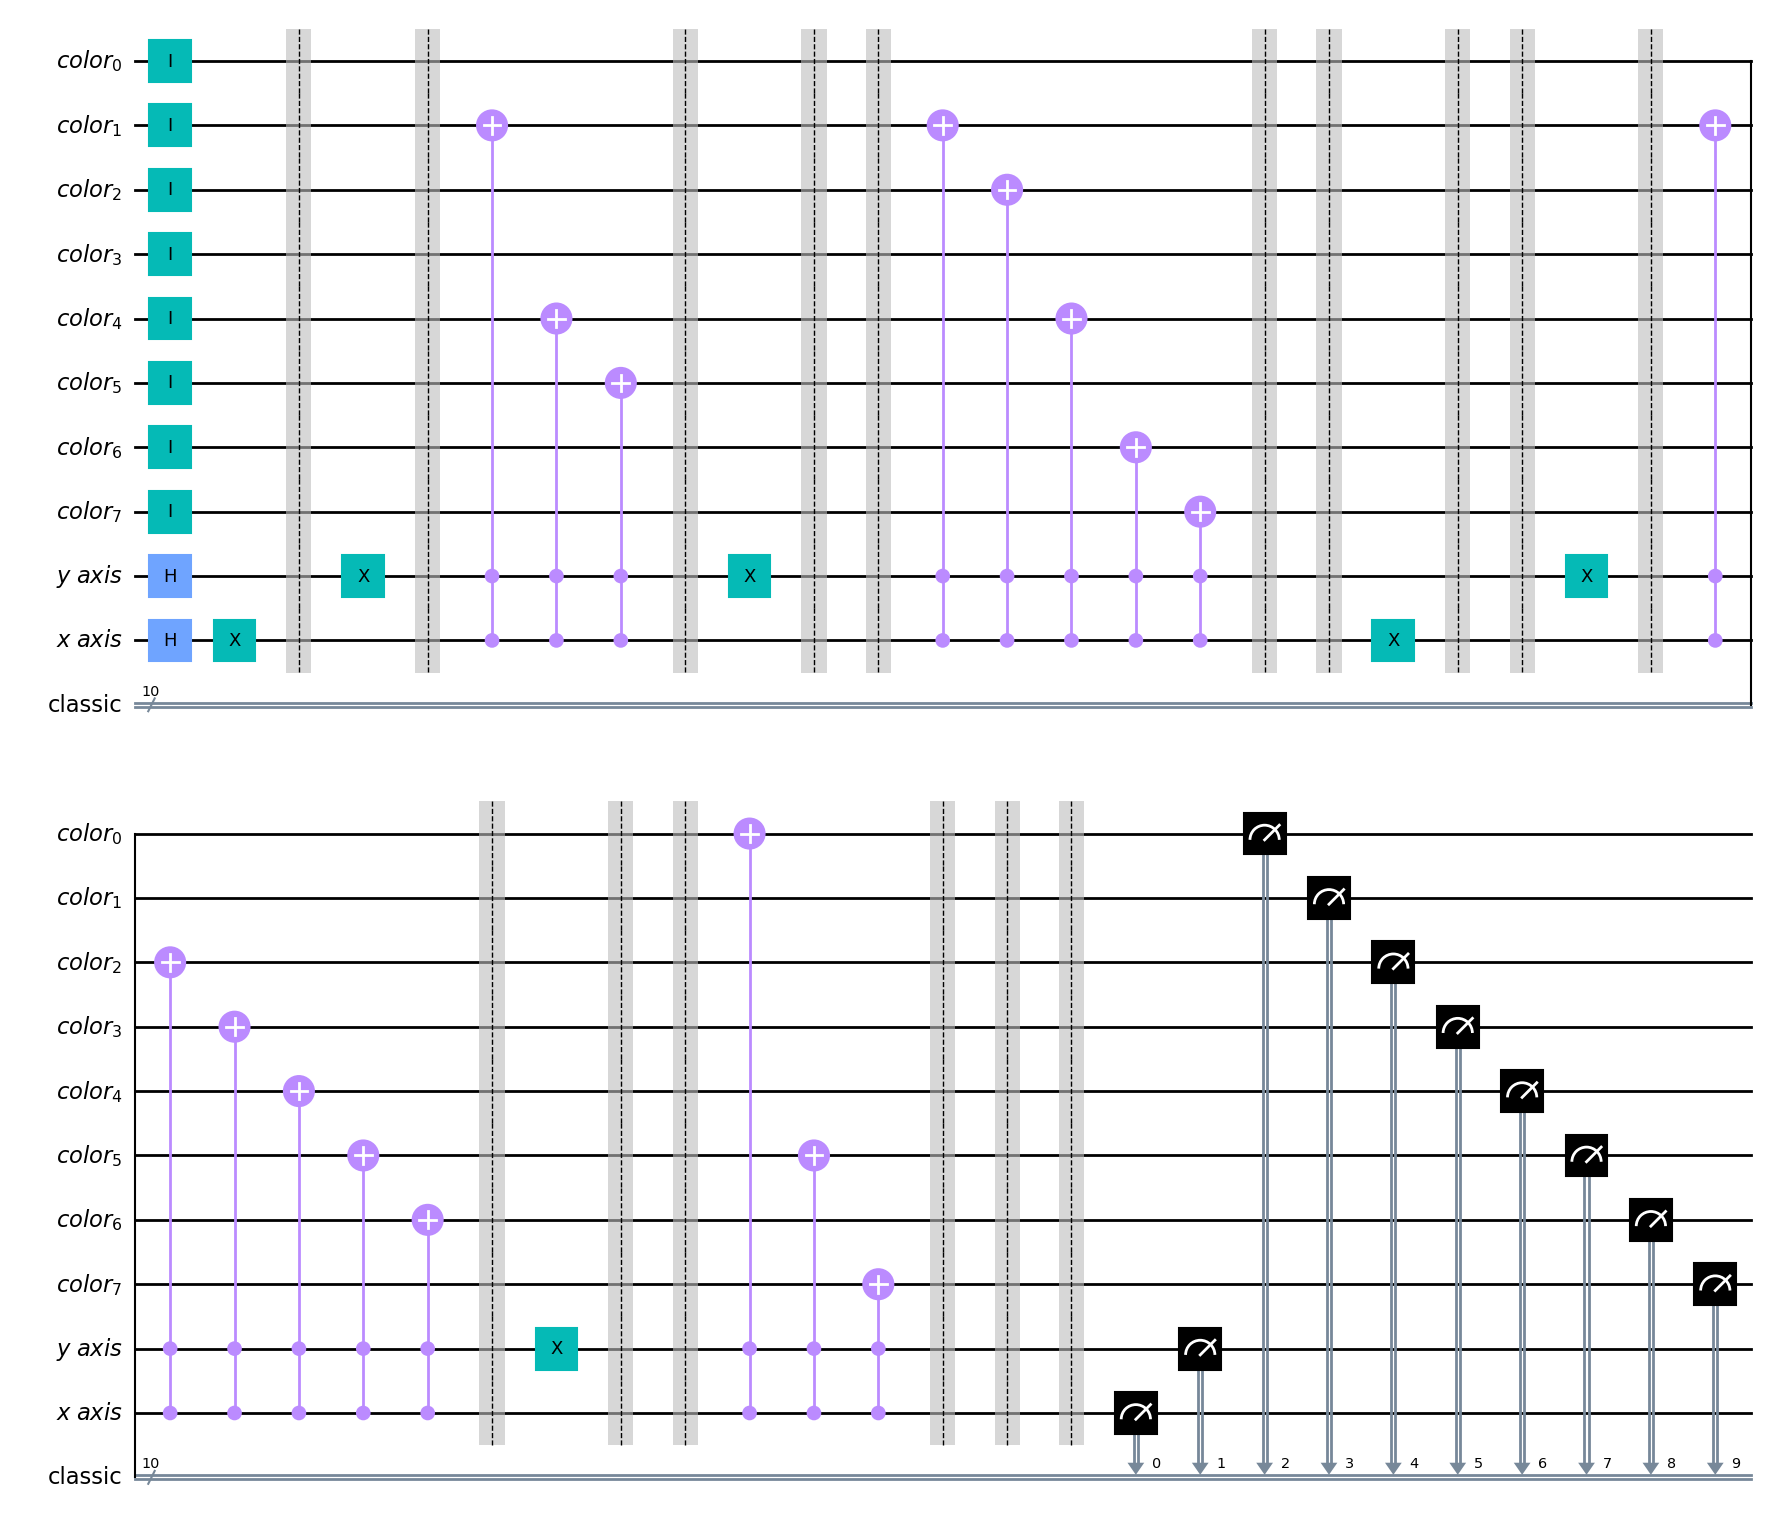

In [16]:
x = int(np.ceil(math.log(image.shape[0], 2)))
if int(x) == 0: x = 1
y = int(np.ceil(math.log(image.shape[1], 2)))
if int(y) == 0: y = 1
q = 8

color = QuantumRegister(q, 'color')
y_ax = QuantumRegister(y, 'y axis')
x_ax = QuantumRegister(x, 'x axis')
classic = ClassicalRegister(x+y+q, 'classic')
qc_gqir = QuantumCircuit(color, y_ax, x_ax, classic)

qc_gqir.id(color)
qc_gqir.h(x_ax)
qc_gqir.h(y_ax)

controls_ = []
for i, _ in enumerate(x_ax):
    controls_.extend([x_ax[i]])
for i, _ in enumerate(y_ax):
    controls_.extend([y_ax[i]])  
for xi in range(image.shape[0]):
    xi_bin = "{0:b}".format(xi).zfill(x_ax.size)
    for i, bit in enumerate(xi_bin):
        if not int(bit):
            qc_gqir.x(x_ax[i])  
    qc_gqir.barrier()
    for yi in range(image.shape[1]):
        yi_bin = "{0:b}".format(yi).zfill(y_ax.size)
        for i, bit in enumerate(yi_bin):
            if not int(bit):
                qc_gqir.x(y_ax[i]) 
        qc_gqir.barrier()
        intensity_bin = "{0:b}".format(image[xi, yi]).zfill(len(color))
        xg = XGate(None).control(len(controls_))
        target = []
        for i, bit in enumerate(intensity_bin):
            if int(bit):
                qc_gqir.mcx(controls_, color[i])
        qc_gqir.barrier()
        for i, bit in enumerate(yi_bin):
            if not int(bit):
                qc_gqir.x(y_ax[i])
        qc_gqir.barrier()
    for i, bit in enumerate(xi_bin):
        if not int(bit):
            qc_gqir.x(x_ax[i])
    qc_gqir.barrier()

qc_gqir.measure(x_ax, range(x_ax.size))
qc_gqir.measure(y_ax, range(x_ax.size, x_ax.size+y_ax.size))
qc_gqir.measure(color, range(x_ax.size+y_ax.size,x_ax.size+y_ax.size+color.size))
qc_gqir.draw('mpl')

# OQIM

C:\Users\HCI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


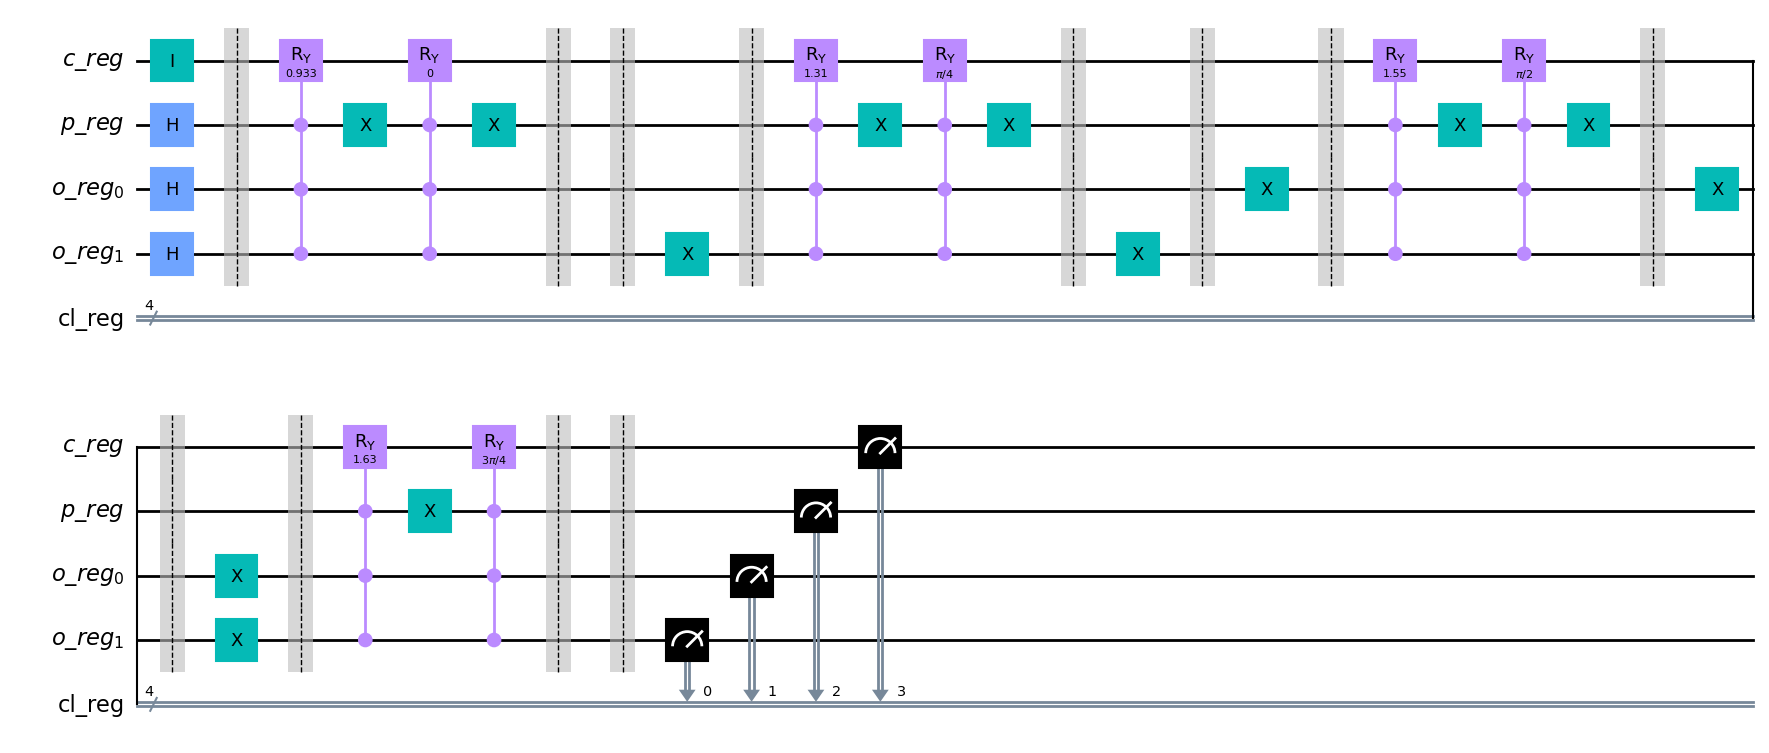

In [20]:
w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

im_list = image.flatten()
ind_list = sorted(range(len(im_list)), key=lambda k:im_list[k])
max_index = max(ind_list)
#now in angles: theta = intensity, phi = coordinate
thetas = np.interp(im_list, (0, 256), (0, np.pi/2))
phis = np.interp(range(len(im_list)), (0, len(im_list)), (0, np.pi/2))

num_ind_bits = int(np.ceil(math.log(len(im_list),2)))
if not num_ind_bits:
    num_ind_bits = 1
O = QuantumRegister(num_ind_bits, 'o_reg')
c = QuantumRegister(1,'c_reg')
p = QuantumRegister(1, 'p_reg')
cr = ClassicalRegister(O.size+c.size+p.size, "cl_reg")

qc_oqim = QuantumCircuit(c, p, O, cr)
num_qubits = qc_oqim.num_qubits
input_im = image.copy().flatten()
qc_oqim.id(c)
qc_oqim.h(O)
qc_oqim.h(p)
controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])
for i, _ in enumerate(p):
    controls_.extend([p[i]]) 

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_oqim.x(O[k])
            
    qc_oqim.barrier()
    
    for coord_or_intns in (0,1):
        if not coord_or_intns:
            ccry_theta = RYGate(2*theta).control(3,label=None)
            qc_oqim.append(ccry_theta,[3,2,1,0])
            '''
            qc_oqim.mcry(theta=2*theta,
                          q_controls=controls_,
                          use_basis_gates=False,
                          q_target=c[0])
            '''
        else:
    
            qc_oqim.x(p)
            ccry_phi = RYGate(2*phi).control(3,label=None)
            qc_oqim.append(ccry_phi,[3,2,1,0])
            '''
            qc_oqim.mcry(theta=2*phi,
                          q_controls=controls_,
                          use_basis_gates=False,
                          q_target=c[0])
            '''
            if i!=len(thetas) - 1:
                qc_oqim.x(p)
       
    qc_oqim.barrier()
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_oqim.x(O[k])
           
    qc_oqim.barrier()

qc_oqim.measure(list(reversed(range(qc_oqim.num_qubits))), list(range(cr.size)))
qc_oqim.draw('mpl')